# Time Series Forecasting - Stock Prices

In [11]:
#!pip3 install tiingo[pandas]

In [12]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
import keras
from tiingo import TiingoClient

In [13]:
# Stream stock price data from Tiingo's API
client = TiingoClient({"session":True, "api_key":"3b31c3a06438982185ad2b3ff8ebd80550371a4a"})

ticker = "IBM"

dt_end = datetime.datetime.now()
dt_start = datetime.datetime.fromtimestamp(0)
tiingo_df = client.get_dataframe(ticker, frequency='daily', startDate=dt_start, endDate=dt_end)
df = tiingo_df[tiingo_df.columns[5:5+4]]
df.columns = ['close', 'high', 'low', 'open']
df

,close,high,low,open
date,,,,
1970-01-02 00:00:00+00:00,8.150767,8.173114,8.134008,8.145181
1970-01-05 00:00:00+00:00,8.228979,8.228979,8.178700,8.178700
1970-01-06 00:00:00+00:00,8.234566,8.245739,8.184287,8.228979
1970-01-07 00:00:00+00:00,8.240152,8.240152,8.184287,8.234566
1970-01-08 00:00:00+00:00,8.256912,8.256912,8.212219,8.240152
...,...,...,...,...
2021-06-07 00:00:00+00:00,148.020000,148.740000,147.170000,147.550000
2021-06-08 00:00:00+00:00,149.070000,150.200000,148.120000,148.120000
2021-06-09 00:00:00+00:00,150.670000,151.070000,148.820000,149.030000


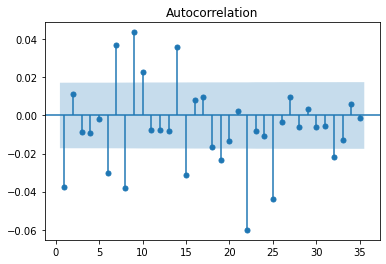

In [14]:
arr = pd.Series(df['close'].diff())
plot_acf(arr[1:], lags = 35, zero=False)
plt.show()

In [15]:
def create_dataset(df, time_steps):
    samples = []
    date = []
    for counter in range(0,df.shape[0]-time_steps):
        samples.append((df.iloc[counter:counter+time_steps]/df.iloc[counter+time_steps]).values)
        date.append(df.index[counter+time_steps])
    return samples, date

In [16]:
def create_lstm(seq_shape, layer_size_array):    
    encoder_layers = []
    
    decoder_layers = []

    repeat_vector = [keras.layers.RepeatVector(n=seq_shape[0])]

    time_distributed = [keras.layers.TimeDistributed(keras.layers.Dense(units=seq_shape[1]))]

    for layer_size, counter in zip(layer_size_array, range(len(layer_size_array))):
        if(counter==0 and counter==(len(layer_size_array)-1)):
            encoder_layers.append(keras.layers.LSTM(units=layer_size, input_shape=seq_shape, return_sequences=False))
        elif(counter==0):
            encoder_layers.append(keras.layers.LSTM(units=layer_size, input_shape=seq_shape, return_sequences=True))
        elif(counter!=(len(layer_size_array)-1)):
            encoder_layers.append(keras.layers.LSTM(units=layer_size, return_sequences=True))
        else:
            encoder_layers.append(keras.layers.LSTM(units=layer_size, return_sequences=False))
        decoder_layers.append(keras.layers.LSTM(units=layer_size, return_sequences=True))
    layers = encoder_layers + repeat_vector + list(reversed(decoder_layers)) + time_distributed
    
    model = keras.Sequential(layers)

    model.compile(loss='mean_absolute_error', optimizer='adam')

    return model

In [17]:
train_df = df[:-df.shape[0]//3]
test_df = df[-df.shape[0]//3:]
display(train_df)
display(test_df)

,close,high,low,open
date,,,,
1970-01-02 00:00:00+00:00,8.150767,8.173114,8.134008,8.145181
1970-01-05 00:00:00+00:00,8.228979,8.228979,8.178700,8.178700
1970-01-06 00:00:00+00:00,8.234566,8.245739,8.184287,8.228979
1970-01-07 00:00:00+00:00,8.240152,8.240152,8.184287,8.234566
1970-01-08 00:00:00+00:00,8.256912,8.256912,8.212219,8.240152
...,...,...,...,...
2004-03-31 00:00:00+00:00,58.563259,58.818326,58.352830,58.709923
2004-04-01 00:00:00+00:00,58.901222,59.098899,58.422973,58.454856
2004-04-02 00:00:00+00:00,60.068152,60.291335,59.513382,59.653669


,close,high,low,open
date,,,,
2004-04-07 00:00:00+00:00,59.353965,59.672799,58.990496,59.538889
2004-04-08 00:00:00+00:00,59.379472,60.189308,59.016002,59.940618
2004-04-12 00:00:00+00:00,59.774825,60.170178,59.558019,59.621785
2004-04-13 00:00:00+00:00,59.328459,59.966125,58.984119,59.806708
2004-04-14 00:00:00+00:00,59.749318,59.851345,58.729053,58.729053
...,...,...,...,...
2021-06-07 00:00:00+00:00,148.020000,148.740000,147.170000,147.550000
2021-06-08 00:00:00+00:00,149.070000,150.200000,148.120000,148.120000
2021-06-09 00:00:00+00:00,150.670000,151.070000,148.820000,149.030000


In [18]:
seq_shape = (30, 4)
layer_size = [int(0.1*seq_shape[0]*seq_shape[1])]

train = create_dataset(train_df, seq_shape[0])
test = create_dataset(test_df, seq_shape[0])

In [19]:
train_mode = True
if(train_mode):
    lstm_auto = create_lstm(seq_shape, layer_size)
    lstm_auto.fit(np.array(train[0]) - 1, np.array(train[0]) - 1, epochs=60, batch_size=100)

Epoch 1/60
87/87 [==============================] - 5s 13ms/step - loss: 0.0427
Epoch 2/60
87/87 [==============================] - 1s 14ms/step - loss: 0.0297
Epoch 3/60
87/87 [==============================] - 1s 14ms/step - loss: 0.0238
Epoch 4/60
87/87 [==============================] - 1s 14ms/step - loss: 0.0188
Epoch 5/60
87/87 [==============================] - 1s 14ms/step - loss: 0.0180
Epoch 6/60
87/87 [==============================] - 1s 14ms/step - loss: 0.0176
Epoch 7/60
87/87 [==============================] - 1s 15ms/step - loss: 0.0170
Epoch 8/60
87/87 [==============================] - 1s 17ms/step - loss: 0.0163
Epoch 9/60
87/87 [==============================] - 1s 15ms/step - loss: 0.0155
Epoch 10/60
87/87 [==============================] - 1s 16ms/step - loss: 0.0151
Epoch 11/60
87/87 [==============================] - 2s 17ms/step - loss: 0.0150
Epoch 12/60
87/87 [==============================] - 1s 16ms/step - loss: 0.0147
Epoch 13/60
87/87 [==================

In [20]:
error = np.abs(lstm_auto.predict(np.array(test[0]) - 1) - (np.array(test[0]) - 1))
error = error.reshape(error.shape[0], error.shape[1]*error.shape[2])
err_ser = pd.Series(error.mean(axis=1))
err_ser.index = test[1]
err_ser

2004-05-20 00:00:00+00:00    0.006538
2004-05-21 00:00:00+00:00    0.006840
2004-05-24 00:00:00+00:00    0.006839
2004-05-25 00:00:00+00:00    0.007543
2004-05-26 00:00:00+00:00    0.006592
                               ...   
2021-06-07 00:00:00+00:00    0.005852
2021-06-08 00:00:00+00:00    0.006067
2021-06-09 00:00:00+00:00    0.006353
2021-06-10 00:00:00+00:00    0.006468
2021-06-11 00:00:00+00:00    0.005570
Length: 4295, dtype: float64

In [21]:
mean =  err_ser.rolling(250).mean().dropna()
std =  err_ser.rolling(250).std().dropna()
err_ser_sub =  err_ser.loc[std.index[0]:]
err_ser_sub

2005-05-17 00:00:00+00:00    0.021902
2005-05-18 00:00:00+00:00    0.023832
2005-05-19 00:00:00+00:00    0.027592
2005-05-20 00:00:00+00:00    0.030131
2005-05-23 00:00:00+00:00    0.028962
                               ...   
2021-06-07 00:00:00+00:00    0.005852
2021-06-08 00:00:00+00:00    0.006067
2021-06-09 00:00:00+00:00    0.006353
2021-06-10 00:00:00+00:00    0.006468
2021-06-11 00:00:00+00:00    0.005570
Length: 4046, dtype: float64

In [22]:
vol_time_series = (df['close'].rolling(30).std()/df['close']).loc[err_ser_sub.index[0]:]
price_time_series = df['close'].loc[err_ser_sub.index[0]:]

In [23]:
def multi_color_line_plotter(x ,y , condition):
    plt.figure(figsize=(14,6))

    for x1, x2, y1,y2, cond in zip(x, x[1:], y, y[1:], condition):
        if cond:
            plt.plot([y1, y2], [x1, x2], '#eb7734')
        else:
            plt.plot([y1, y2], [x1, x2], '#34a1eb')

    plt.show()

PRICE SERIES DATA


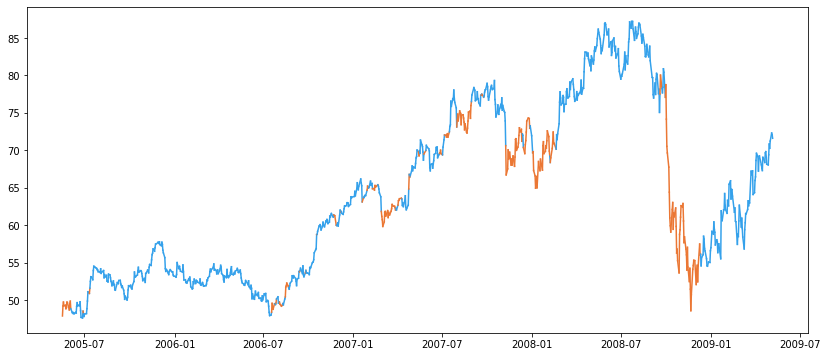

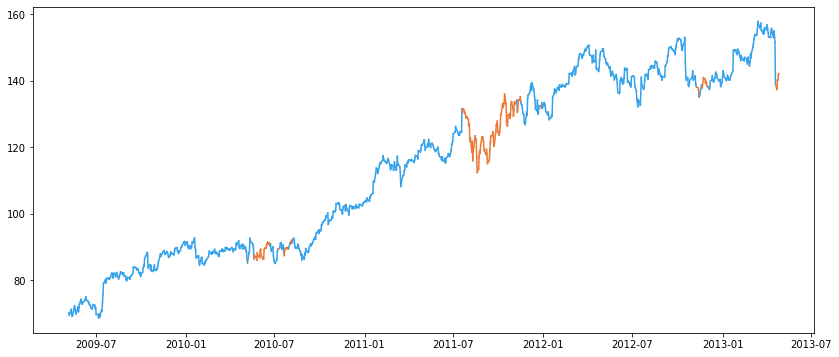

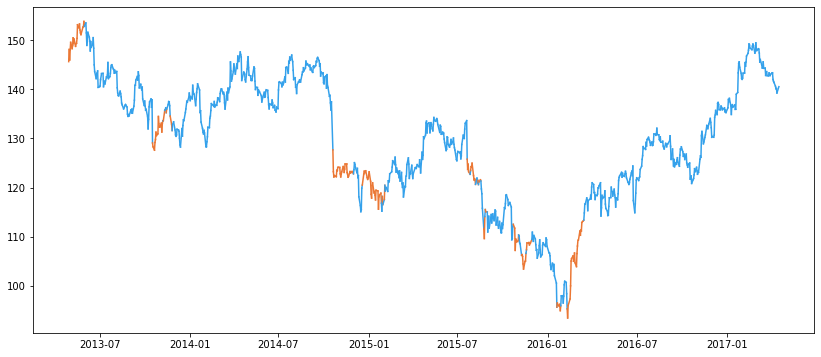

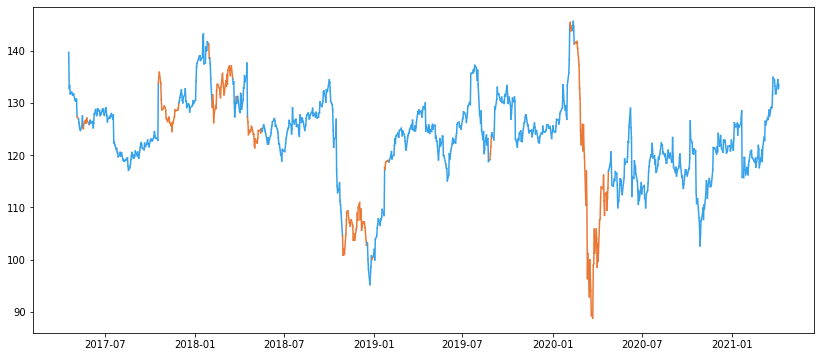

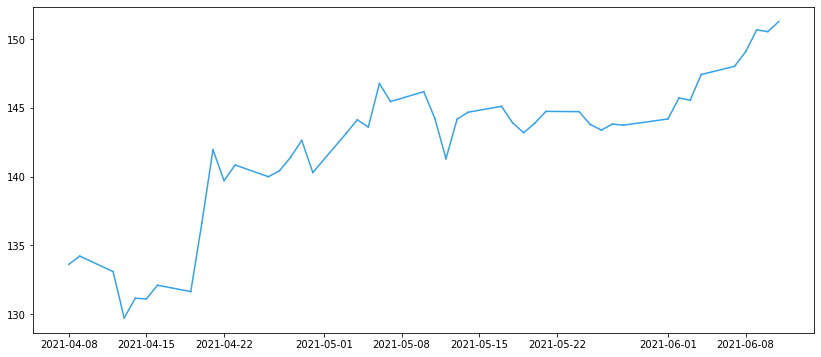

VOLUME SERIES DATA


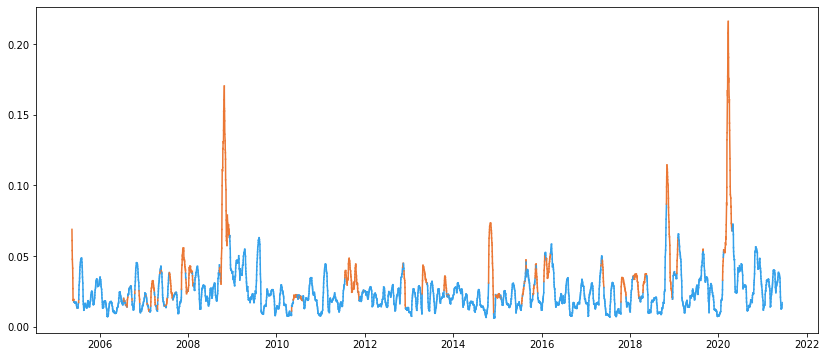

In [24]:
condition = (err_ser_sub>(mean+(1*std)))

print("PRICE SERIES DATA")
for counter in range(0,5000,1000):
    multi_color_line_plotter(price_time_series.iloc[counter:counter+1000],
                             price_time_series.iloc[counter:counter+1000].index,
                             condition.iloc[counter:counter+1000])
    
print("VOLUME SERIES DATA")

multi_color_line_plotter(vol_time_series,
                             vol_time_series.index,
                             condition)

In [25]:
stats.ttest_ind(vol_time_series[condition], vol_time_series[condition.apply(lambda x : not x)]).pvalue

3.346401346125253e-178